In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import torch.optim as optim

In [2]:
# Device configuration
USE_GPU = True
dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss.
print_every = 100
print('using device:', device)

using device: cuda


In [3]:
# dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [4]:
NUM_TRAIN = 49000

# CIFAR10: 60000 32x32 color images in 10 classes, with 500 training and 100 test images per class

cifar10_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

loader_train = DataLoader(cifar10_train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

loader_val = DataLoader(cifar10_val, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

loader_test = DataLoader(cifar10_test, batch_size=64)

100%|██████████| 170498071/170498071 [00:01<00:00, 99177539.73it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [24]:
classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [6]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


In [7]:
# get some random training images
dataiter = iter(loader_train)
images, labels = next(dataiter)

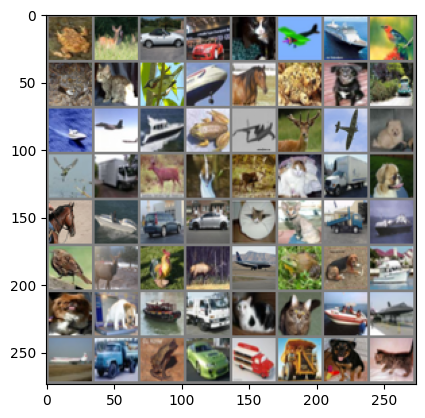

In [8]:
# show images
imshow(torchvision.utils.make_grid(images))


In [9]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

In [13]:
def check_accuracy(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [15]:
def train_model(model, optimizer, epochs=1):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy(loader_val, model)
                print()

In [17]:
learning_rate = 5e-3

class Flatten(nn.Module):
  def forward(self, x):
    return flatten(x)

model = nn.Sequential(
    nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = (3,3), padding=1),
    nn.ReLU(),

    nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = (3,3), padding=1),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),

    nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (3,3), padding=1),
    nn.ReLU(),

    nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = (3,3), padding=1),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),

    nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (3,3), padding=1),
    nn.ReLU(),

    nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = (3,3), padding=1),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    
    Flatten(),
    nn.Linear(in_features =128*4*4, out_features=512),
    nn.Linear(in_features =512, out_features=128),
    nn.Linear(in_features =128, out_features=10),
)

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [18]:
train_model(model, optimizer, epochs=20) #Training the model and testing on validation set

Iteration 0, loss = 2.2973
Checking accuracy on validation set
Got 112 / 1000 correct (11.20)

Iteration 100, loss = 2.3021
Checking accuracy on validation set
Got 112 / 1000 correct (11.20)

Iteration 200, loss = 2.2990
Checking accuracy on validation set
Got 87 / 1000 correct (8.70)

Iteration 300, loss = 2.3021
Checking accuracy on validation set
Got 105 / 1000 correct (10.50)

Iteration 400, loss = 2.2985
Checking accuracy on validation set
Got 105 / 1000 correct (10.50)

Iteration 500, loss = 2.3012
Checking accuracy on validation set
Got 87 / 1000 correct (8.70)

Iteration 600, loss = 2.3014
Checking accuracy on validation set
Got 155 / 1000 correct (15.50)

Iteration 700, loss = 2.2984
Checking accuracy on validation set
Got 80 / 1000 correct (8.00)

Iteration 0, loss = 2.3037
Checking accuracy on validation set
Got 119 / 1000 correct (11.90)

Iteration 100, loss = 2.3008
Checking accuracy on validation set
Got 87 / 1000 correct (8.70)

Iteration 200, loss = 2.3059
Checking accu

In [19]:
check_accuracy(loader_test, model) #Testing the model

Checking accuracy on test set
Got 7639 / 10000 correct (76.39)


In [20]:
print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

Finished Training


In [21]:
# Translate categorial to array for drawing confusion matrix
from sklearn import metrics
from numpy import argmax
y_true =[]
y_pred =[]
for images, labels in loader_test:
  images = images.to(device)
  labels = labels.to(device).cpu().data.numpy().argmax()
  outputs = model(images)
  _, predicted = torch.max(outputs, 1)
  y_pred.append(predicted.cpu().data.numpy().argmax())
  y_true.append(labels)

print(y_pred)
print(y_true)

cm = metrics.confusion_matrix(y_pred, y_true)

[11, 25, 5, 17, 24, 11, 10, 3, 5, 9, 4, 3, 12, 6, 25, 0, 36, 16, 19, 5, 2, 0, 9, 3, 27, 1, 4, 6, 0, 25, 7, 3, 23, 4, 1, 4, 1, 14, 0, 0, 8, 32, 5, 2, 1, 7, 0, 21, 9, 5, 8, 18, 16, 0, 13, 11, 25, 7, 15, 24, 1, 7, 2, 38, 2, 8, 9, 1, 11, 1, 0, 25, 1, 6, 1, 0, 1, 0, 36, 0, 16, 8, 0, 3, 15, 0, 8, 5, 28, 24, 3, 8, 5, 0, 1, 22, 2, 10, 2, 1, 9, 9, 14, 10, 16, 4, 0, 4, 0, 31, 4, 9, 2, 0, 1, 2, 0, 3, 11, 6, 14, 8, 10, 0, 6, 0, 1, 10, 7, 29, 3, 22, 5, 0, 9, 4, 22, 28, 17, 12, 12, 2, 8, 7, 1, 0, 13, 1, 12, 9, 23, 3, 4, 4, 12, 7, 1]
[11, 12, 5, 17, 3, 11, 10, 3, 5, 1, 4, 3, 12, 6, 25, 0, 36, 16, 3, 4, 2, 0, 9, 3, 27, 1, 4, 4, 0, 25, 4, 3, 11, 4, 1, 0, 1, 14, 0, 0, 8, 32, 5, 2, 1, 7, 0, 28, 9, 5, 8, 18, 11, 3, 3, 22, 25, 7, 15, 0, 1, 7, 2, 38, 2, 8, 9, 5, 11, 1, 0, 6, 11, 6, 1, 0, 2, 0, 36, 7, 0, 8, 0, 3, 15, 0, 8, 5, 28, 24, 3, 8, 5, 0, 1, 15, 3, 10, 2, 1, 9, 5, 14, 11, 16, 4, 0, 0, 20, 7, 6, 9, 2, 0, 1, 2, 0, 3, 1, 6, 5, 8, 10, 0, 6, 0, 1, 15, 25, 16, 3, 1, 2, 0, 9, 12, 22, 28, 17, 12, 12, 2, 8, 7,

[[19  0  0 ...  0  0  0]
 [ 0 13  2 ...  0  0  0]
 [ 0  0  8 ...  0  0  0]
 ...
 [ 0  0  0 ...  1  0  0]
 [ 0  0  0 ...  0  2  0]
 [ 0  0  0 ...  0  0  1]]


<ipython-input-25-29f2d7eea864>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + classes)
<ipython-input-25-29f2d7eea864>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + classes)


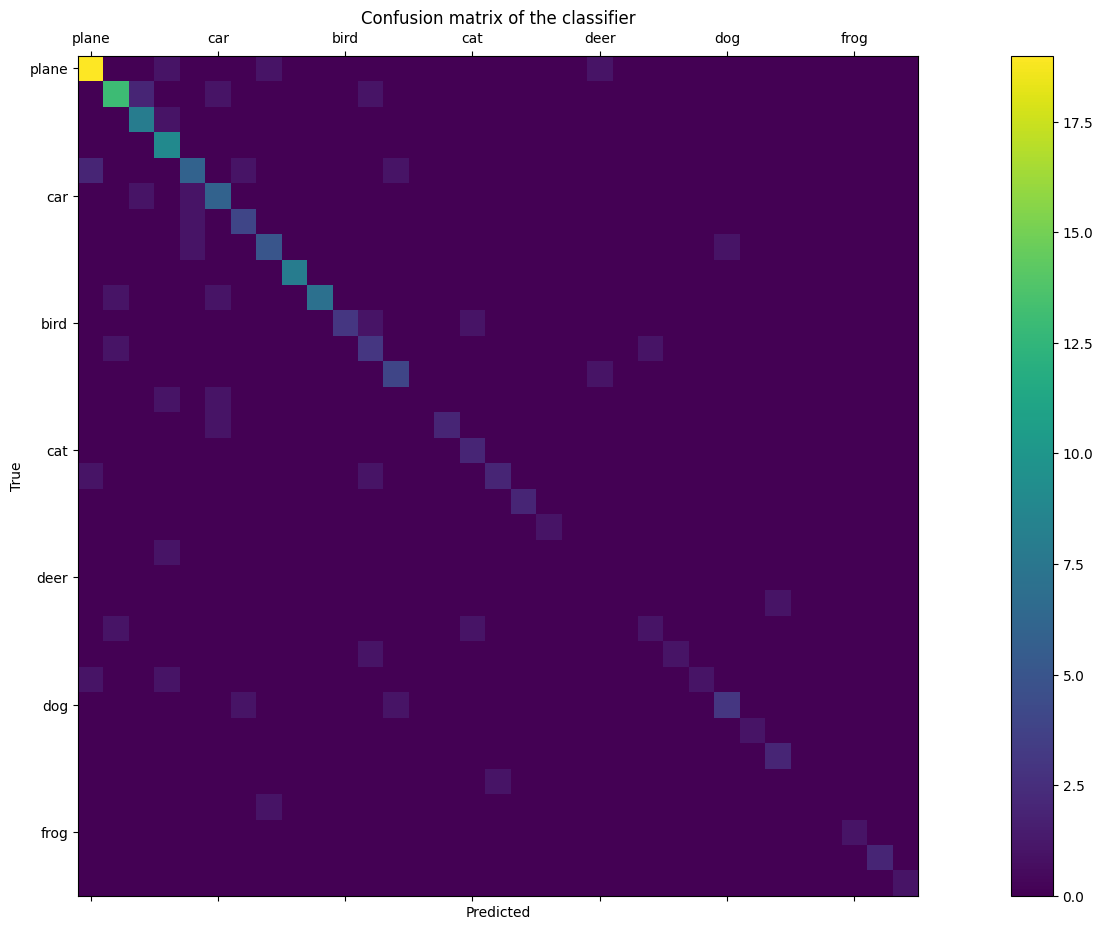

In [25]:
# Plot the confusion matrix
import matplotlib.pyplot as plt
print(cm)
fig = plt.figure(figsize=(24,24))
ax = fig.add_subplot(211)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + classes)
ax.set_yticklabels([''] + classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [26]:
# Calculating f1 score
from sklearn.metrics import f1_score
print(f"f1 score: {f1_score(y_true, y_pred, average='weighted')}")

f1 score: 0.7563836955538481


In [28]:
labels = []
for i in range(10):
  labels.append(i+1)
print(labels)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=classes, digits=5, labels = labels))

              precision    recall  f1-score   support

       plane    0.76471   0.81250   0.78788        16
         car    0.88889   0.72727   0.80000        11
        bird    1.00000   0.64286   0.78261        14
         cat    0.60000   0.66667   0.63158         9
        deer    0.75000   0.60000   0.66667        10
         dog    0.80000   0.66667   0.72727         6
        frog    0.71429   0.71429   0.71429         7
       horse    1.00000   1.00000   1.00000         8
        ship    0.77778   1.00000   0.87500         7
       truck    0.60000   1.00000   0.75000         3

   micro avg    0.79310   0.75824   0.77528        91
   macro avg    0.78957   0.78302   0.77353        91
weighted avg    0.81272   0.75824   0.77420        91

